In [58]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
df = pd.read_csv("Tweets.csv")

In [3]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,negativereason_gold,retweet_count,text,tweet_coord
0,5.703061e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,NaN,0,@VirginAmerica What @dhepburn said.,NaN
1,5.703011e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,NaN,0,@VirginAmerica plus you've added commercials t...,NaN
2,5.703011e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN
4,5.703008e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN


In [4]:
null_columns = df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

negativereason                5462
negativereason_confidence     4118
airline_sentiment_gold       14600
negativereason_gold          14608
tweet_coord                  13621
dtype: int64

In [5]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [6]:
df = df.drop(["tweet_id", "airline_sentiment_gold", "negativereason_gold","tweet_coord"],axis=1)

In [7]:
df.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,retweet_count,text
0,neutral,1.0000,NaN,NaN,Virgin America,0,@VirginAmerica What @dhepburn said.
1,positive,0.3486,NaN,0.0000,Virgin America,0,@VirginAmerica plus you've added commercials t...
2,neutral,0.6837,NaN,NaN,Virgin America,0,@VirginAmerica I didn't today... Must mean I n...
3,negative,1.0000,Bad Flight,0.7033,Virgin America,0,@VirginAmerica it's really aggressive to blast...
4,negative,1.0000,Can't Tell,1.0000,Virgin America,0,@VirginAmerica and it's a really big bad thing...


In [8]:
null_columns = df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

negativereason               5462
negativereason_confidence    4118
dtype: int64

In [9]:
y = df["airline_sentiment"].values
X = df.drop(["airline_sentiment"],axis=1)

In [10]:
print(X.describe())

       airline_sentiment_confidence  negativereason_confidence  retweet_count
count                  14640.000000               10522.000000   14640.000000
mean                       0.900169                   0.638298       0.082650
std                        0.162830                   0.330440       0.745778
min                        0.335000                   0.000000       0.000000
25%                        0.692300                   0.360600       0.000000
50%                        1.000000                   0.670600       0.000000
75%                        1.000000                   1.000000       0.000000
max                        1.000000                   1.000000      44.000000


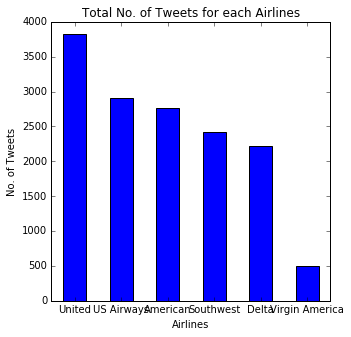

In [11]:
pd.Series(df["airline"]).value_counts().plot(kind = "bar",figsize=(5,5),rot = 0, 
                                             title = "Total No. of Tweets for each Airlines")
plt.xlabel('Airlines')
plt.ylabel('No. of Tweets')

In [12]:
df.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

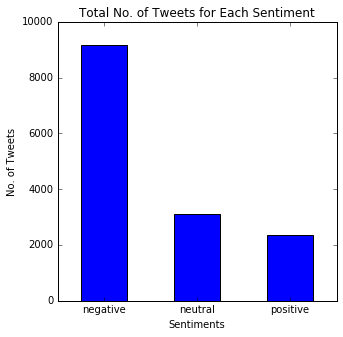

In [13]:
pd.Series(df["airline_sentiment"]).value_counts().plot(kind = "bar", figsize=(5,5),rot=0, 
                                                       title = "Total No. of Tweets for Each Sentiment")
plt.xlabel('Sentiments')
plt.ylabel('No. of Tweets')

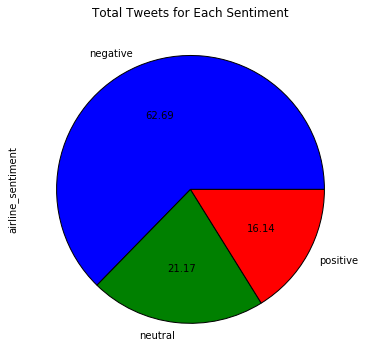

In [14]:
pd.Series(df["airline_sentiment"]).value_counts().plot(kind="pie",labels=["negative", "neutral", "positive"],
                                                       autopct='%.2f', figsize=(6, 6),
                                                       title = "Total Tweets for Each Sentiment")

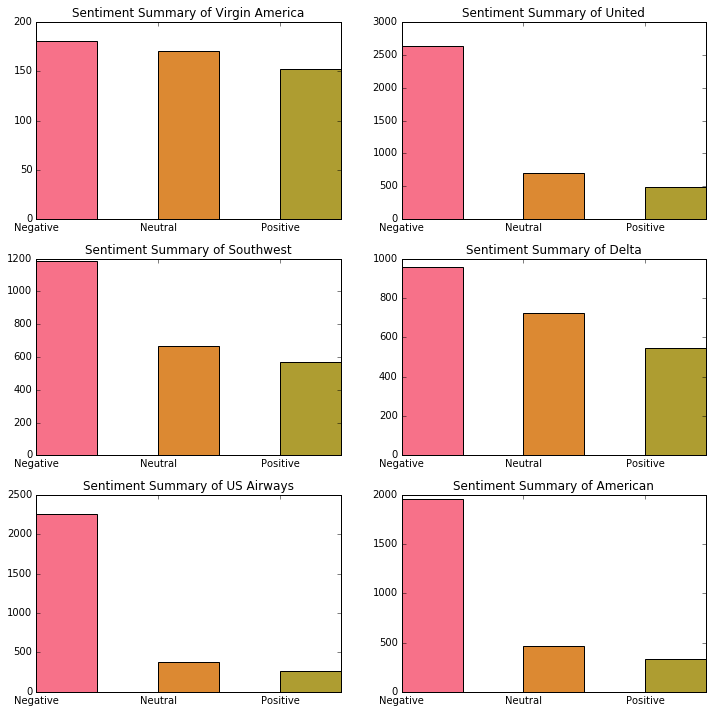

In [15]:
def plot_sub_sentiment(Airline):
    pdf = df[df['airline']==Airline]
    count = pdf['airline_sentiment'].value_counts()
    Index = [1,2,3]
    color=sns.color_palette("husl", 10)
    plt.bar(Index,count,width=0.5,color=color)
    plt.xticks(Index,['Negative','Neutral','Positive'])
    plt.title('Sentiment Summary of' + " " + Airline)

airline_name = df['airline'].unique()
plt.figure(1,figsize=(12,12))
for i in range(6):
    plt.subplot(3,2,i+1)
    plot_sub_sentiment(airline_name[i])


In [16]:
df.negativereason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

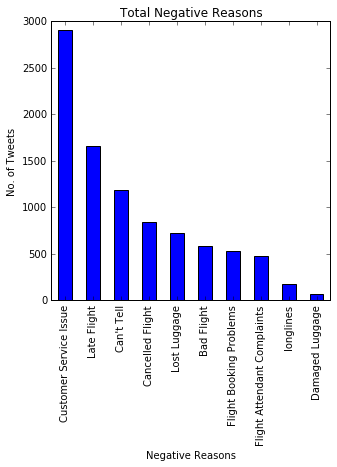

In [17]:
#Plotting all the negative reasons 
pd.Series(df["negativereason"]).value_counts().plot(kind = "bar",
                        figsize=(5,5),title = "Total Negative Reasons")
plt.xlabel('Negative Reasons', fontsize=10)
plt.ylabel('No. of Tweets', fontsize=10)

In [18]:
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

In [19]:
airline_sentiment = list(df["airline_sentiment"])

In [20]:
le = LabelEncoder()
airline_sentiment = le.fit_transform(airline_sentiment)

In [21]:
df = df.drop(["airline_sentiment"],axis=1)

In [22]:
df["airline_sentiment"] = airline_sentiment

In [23]:
null_columns = df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

negativereason               5462
negativereason_confidence    4118
dtype: int64

In [24]:
negative_reason = list(df['negativereason'])
print(len(set(negative_reason)))

11


In [25]:
le = LabelEncoder()
negative_reason = le.fit_transform(negative_reason)
negative_reason = list(negative_reason)

In [26]:
list(le.classes_)

['Bad Flight',
 "Can't Tell",
 'Cancelled Flight',
 'Customer Service Issue',
 'Damaged Luggage',
 'Flight Attendant Complaints',
 'Flight Booking Problems',
 'Late Flight',
 'Lost Luggage',
 'longlines',
 'nan']

In [27]:
le.inverse_transform([10])

array(['nan'], dtype='<U32')

In [28]:
for i in range(len(negative_reason)):
    if negative_reason[i] == 10:
        negative_reason[i] = np.nan

In [29]:
df = df.drop(["negativereason"],axis=1)
df["negative_reason"] = negative_reason

In [30]:
airline = list(df["airline"])
le = LabelEncoder()
airline = le.fit_transform(airline)
airline = list(airline)

In [31]:
df = df.drop(["airline"],axis=1)
df["airline"] = airline

In [32]:
def tweet_to_words(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words )) 

def clean_tweet_length(raw_tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return(len(meaningful_words)) 

In [33]:
df['clean_tweet'] = df['text'].apply(lambda x: tweet_to_words(x))
df['Tweet_length']= df['text'].apply(lambda x: clean_tweet_length(x))

In [34]:
text = list(df["clean_tweet"])

In [35]:
df = df.drop(["text", "clean_tweet"],axis=1)

In [36]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(text)]
model = Doc2Vec(documents, size=100, window=2, min_count=1, workers=4)

In [37]:
embedding = []
for i in range(len(text)):
    embedding.append(model.infer_vector(text[0]))

In [517]:
#n_imputations = len(df)
#df_completed = []
#for i in range(n_imputations):
#    imputer = IterativeImputer(n_iter=1, sample_posterior=True, random_state=i)
#    df_completed.append(imputer.fit_transform(df)).
#df_completed = np.concatenate(df_completed, axis = 0)

In [39]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

In [41]:
df_complete = imp_mean.fit_transform(df)

In [44]:
X = np.hstack((df_complete, embedding))

In [49]:
le = LabelEncoder()
y = le.fit_transform(y)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [54]:
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [55]:
y_pred = clf.predict(X_test)

In [59]:
cnf_mat = confusion_matrix(y_test, y_pred)
print(cnf_mat)

[[1889    0    0]
 [   0  580    0]
 [   0    0  459]]


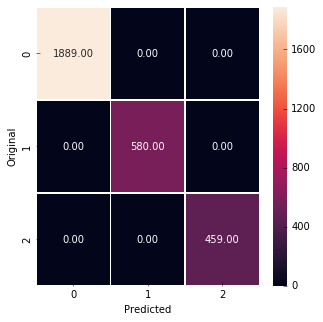

In [62]:
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cnf_mat,annot = True,linewidths=0.5,ax=ax, fmt = '.2f')
plt.xlabel("Predicted")
plt.ylabel("Original")
plt.show()

In [65]:
print("Accuracy = ","{0:.2f}".format(accuracy_score(y_test, y_pred)*100))
print("Precision =","{0:.2f}".format(precision_score(y_test, y_pred, average = 'weighted')))
print("Recall =","{0:.2f}".format(recall_score(y_test, y_pred, average = 'weighted')))
print("F1-score =","{0:.2f}".format(f1_score(y_test, y_pred,average = 'weighted')))

Accuracy =  100.00
Precision = 1.00
Recall = 1.00
F1-score = 1.00
